# TensorFlow/Keras Pre-processing

### We can easily load the images from Kaggle using TensorFlow's ImageDataGenerator. 
### We then use data augmentation in order to 'improve' and normalize the images.

In [29]:
from keras.preprocessing.image import ImageDataGenerator

test_dir = "Testing/"
train_dir = "Training/"

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

testgen = ImageDataGenerator(rescale=1./255)
                             
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150, 150),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=7
)

test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(150, 150),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


# Setting Up the Model

In [30]:
from keras.regularizers import l2

def add_conv_block(model, filters, kernel_size, padding="same", input_shape=None, reg_lambda=0.001):
    if input_shape:
        model.add(Conv2D(filters, kernel_size, padding=padding, input_shape=input_shape, kernel_regularizer=l2(reg_lambda)))
    else:
        model.add(Conv2D(filters, kernel_size, padding=padding, kernel_regularizer=l2(reg_lambda)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

model = Sequential()

# 1st set of layers
add_conv_block(model, 32, (5, 5), input_shape=(150, 150, 1))

# 2nd, 3rd, 4th, 5th set of layers with `MaxPooling`
for filters in [32, 64, 64, 128, 128, 256, 256]:
    add_conv_block(model, filters, (3, 3))
    if filters != 32:
        model.add(MaxPooling2D(padding="same"))

# Flatten the image
model.add(Flatten())

# Fully connected layers with regularization
model.add(Dense(1024, activation="relu", kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])


Halt the training when the model ceases to improve (3 epochs), potentially saving time and computational resources. It can also prevent overfitting by stopping the training before the model begins to memorize the training data at the expense of generalization performance.

In [31]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

callbacks = [early_stopping, reduce_lr]

# Training the Model

In [32]:
model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/10
90/90 [==============================] - 103s 1s/step - loss: 2.5628 - accuracy: 0.3439 - auc: 0.6358 - val_loss: 2.3736 - val_accuracy: 0.2538 - val_auc: 0.4763 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 102s 1s/step - loss: 2.1131 - accuracy: 0.3780 - auc: 0.6961 - val_loss: 2.6101 - val_accuracy: 0.2538 - val_auc: 0.4810 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - 101s 1s/step - loss: 1.9774 - accuracy: 0.4101 - auc: 0.7229 - val_loss: 2.4470 - val_accuracy: 0.2360 - val_auc: 0.4673 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - 102s 1s/step - loss: 1.8411 - accuracy: 0.4537 - auc: 0.7453 - val_loss: 2.1195 - val_accuracy: 0.3528 - val_auc: 0.5743 - lr: 0.0010
Epoch 5/10
90/90 [==============================] - 101s 1s/step - loss: 1.7128 - accuracy: 0.5160 - auc: 0.7771 - val_loss: 2.0286 - val_accuracy: 0.2868 - val_auc: 0.5923 - lr: 0.0010
Epoch 6/10
90/90 [==============================] - 103s 1s/step - los

KeyboardInterrupt: 

# Model Evaluation

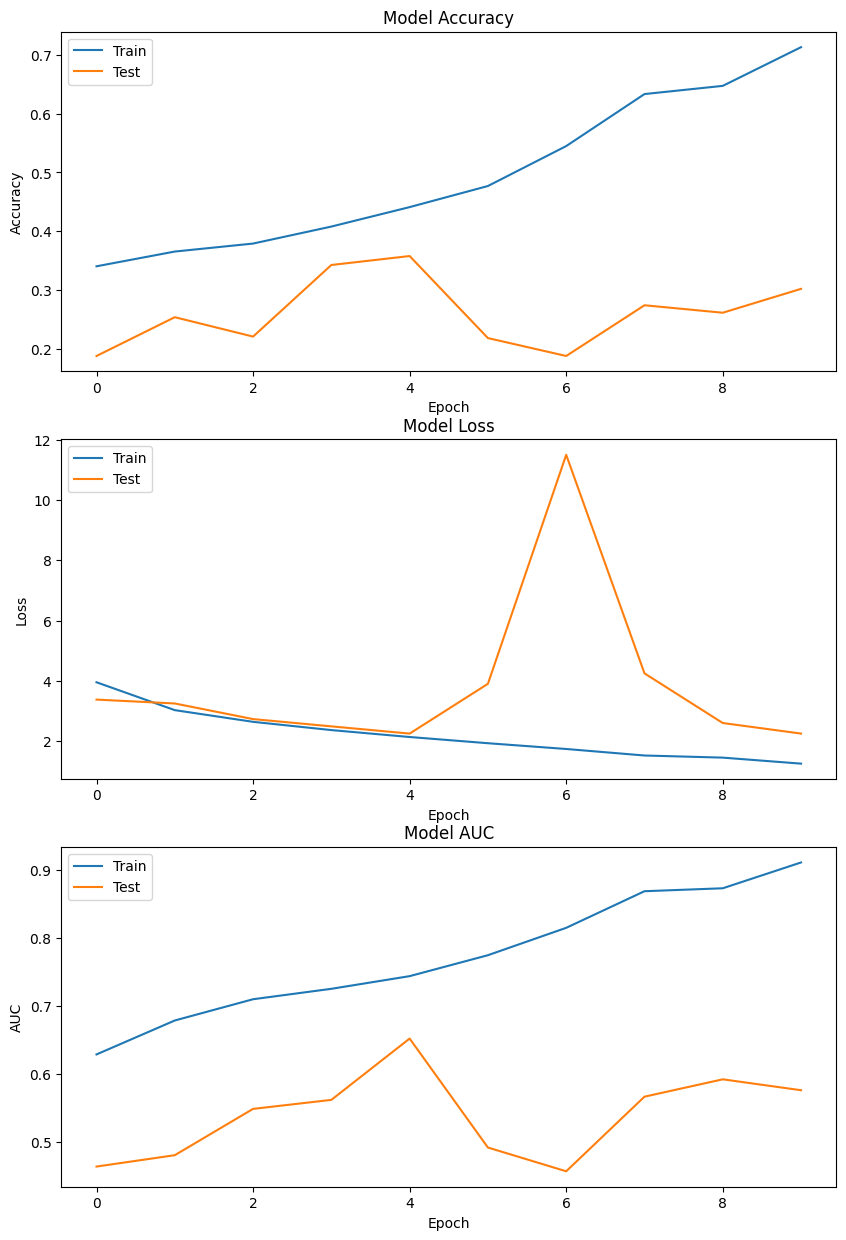

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

points = {
    'accuracy': history.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'],
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'AUC': history.history['auc'],
    'val_AUC': history.history['val_auc'],
}

# Plotting accuracy
axs[0].plot(points['accuracy'])
axs[0].plot(points['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Test'], loc='upper left')

# Plotting loss
axs[1].plot(points['loss'])
axs[1].plot(points['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Test'], loc='upper left')

# Plotting AUC
axs[2].plot(points['AUC'])
axs[2].plot(points['val_AUC'])
axs[2].set_title('Model AUC')
axs[2].set_ylabel('AUC')
axs[2].set_xlabel('Epoch')
axs[2].legend(['Train', 'Test'], loc='upper left')

plt.show()
